In [1]:
import h5py
import numpy as np
import os
import pandas as pd
import pickle
import scipy
import scipy.interpolate
import unyt

In [2]:
import verdict
import trove

In [3]:
import matplotlib
import matplotlib.style
matplotlib.style.use( '/Users/zhafen/repos/clean-bold/clean-bold.mplstyle' )
import matplotlib.pyplot as plt
import matplotlib.gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patheffects as path_effects
import palettable
import voronoi_scatter

# Parameters

In [4]:
sample_i = 0

In [5]:
# Load parameters
pm = trove.link_params_to_config(
    '/Users/zhafen/repos/cgm_modeling_challenge/sample2.trove',
    script_id = 'nb.2',
)

In [6]:
agreement_cmap = palettable.colorbrewer.diverging.PuOr_5.mpl_colormap

In [7]:
figure_dir = pm['figure_dir']
os.makedirs( figure_dir, exist_ok=True )

In [8]:
prop_keys = [ 'l', 'T', 'nH', 'Z', ]

## Plotting

In [9]:
logscale = {
    'l': True,
    'T': True,
    'nH': True,
    'Z': True,
}

In [10]:
labels = {
    'l': r'$\ell$ [kpc]',
    'T': r'T [K]',
    'nH': r'$n_{\rm H}$ [cm$^{-3}$]',
    'Z': r'$Z$ [$Z_{\odot}$]',
}

In [11]:
lims = {
    'T': [ 1e4, 1e6 ],
}

In [12]:
panel_length = 4.

In [13]:
found_color = palettable.cartocolors.qualitative.Safe_10.mpl_colors[1]
revised_color = palettable.cartocolors.qualitative.Safe_10.mpl_colors[0]

# Analysis

## Load Data

### Actual Data

In [14]:
actual = verdict.Dict.from_hdf5( './data/synthetic_data/sample{}/theorists_file.h5'.format( sample_i ) )

/Users/zhafen/repos/verdict/verdict.py:1410: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if hasattr( a[first_element_index][0], 'decode' ):


In [15]:
observers_data = verdict.Dict.from_hdf5( './data/synthetic_data/sample{}/observers_file.h5'.format( sample_i ) )

In [16]:
provided = verdict.Dict.from_hdf5( './data/synthetic_data_samples/sample0.h5' )

### Modeled

#### Sameer & Charlton

In [17]:
modeling_group = 'sameer_charlton'

##### Original Results

In [18]:
modeled_raw = verdict.Dict.from_hdf5( './data/modeling_results/{}/sample{}/sample{}.hdf5'.format( modeling_group, sample_i, sample_i ) )

In [19]:
derived = pd.read_csv( './data/modeling_results/sameer_charlton/sample{}/derived.txt'.format( sample_i ), sep='\t', index_col=0 )

In [20]:
modeled = {
    'metallicity': np.array([ modeled_raw[str(i+1)][0] for i in range( actual['metallicity'].size ) ]),
    'emetallicity': np.array([ modeled_raw[str(i+1)][1] for i in range( actual['metallicity'].size ) ]),
    'length': derived.values[:,0],
    'H_column': derived.values[:,1],
    'temperature': derived.values[:,2],
    'H_density': derived.values[:,3],
}

In [21]:
fp = './data/modeling_results/{}/sample{}/firstiteration.pickle'.format( modeling_group, sample_i )
columns = dict( pd.read_pickle( fp ) )

In [22]:
for key, item in columns.items():
    item_arr = np.array(item)
    modeled['{}'.format( key )] = item_arr[:,0]
    modeled['e{}'.format( key )] = item_arr[:,1]

In [23]:
modeled = pd.DataFrame( modeled )
modeled = modeled.set_index( np.arange( modeled.shape[0] ) + 1 )

In [24]:
modeled

,metallicity,emetallicity,length,H_column,temperature,H_density,CII,eCII,CIII,eCIII,...,OI,eOI,OVI,eOVI,SiII,eSiII,SiIII,eSiIII,SiIV,eSiIV
1,0.06,0.01,21.00,7.740000e+20,4.84,-1.93,15.691484,0.000397,17.929363,0.000736,...,11.715133,0.002775,11.391069,0.406664,13.754917,0.001619,15.671558,0.001692,16.188546,0.002024
2,-2.12,0.08,180384.00,7.000000e+22,5.27,-3.90,11.236898,0.142707,14.271502,0.262852,...,8.120460,0.101628,15.791052,0.444403,8.702203,0.150661,11.557654,0.222482,13.421160,0.402905
3,-0.96,0.01,42.00,1.290000e+22,4.81,-0.89,11.452974,0.060688,14.058547,0.072851,...,8.549668,0.042678,14.363366,0.067732,9.257747,0.063399,11.994727,0.069309,13.464749,0.078703
4,-1.26,0.04,78324.00,3.040000e+22,5.52,-3.90,9.407875,0.141925,12.637533,0.105735,...,5.869771,0.289857,17.187370,0.108131,7.917200,0.114995,11.244864,0.104229,13.461248,0.100126
5,-1.89,0.09,1420.00,5.510000e+20,5.36,-3.90,9.063061,0.178609,11.629490,0.188981,...,6.827060,0.162749,14.509384,0.346610,6.813114,0.196643,9.743890,0.215566,11.341659,0.256888
6,-0.58,0.01,1452.00,6.180000e+20,4.98,-3.86,12.396806,0.000000,14.727852,0.000000,...,9.610236,0.000000,17.138521,0.000000,9.967403,0.000000,12.913004,0.000000,14.925108,0.000000
7,-0.34,0.01,2321.00,1.030000e+21,4.83,-3.84,14.157700,0.909748,16.425938,0.692740,...,10.724278,0.286063,15.573233,0.749450,11.512939,0.902073,13.872227,0.599159,14.976804,0.213480
8,-0.80,0.04,2.75,6.580000e+18,4.47,-3.10,13.863359,0.092392,14.367747,0.084591,...,10.898901,0.077936,11.451013,0.125161,12.240640,0.045588,13.464762,0.057335,12.639110,0.061169
9,0.26,0.17,37.00,8.540000e+18,4.68,-4.07,14.351662,0.112084,15.371783,0.153434,...,10.405686,0.374422,14.281810,0.245339,11.927297,0.589081,13.368003,0.318121,13.037409,0.279005
10,0.05,0.03,0.38,7.600000e+17,4.33,-3.20,13.415714,0.043321,14.188974,0.058783,...,11.002025,0.078484,11.280133,0.045110,12.144853,0.062068,13.254984,0.054315,12.657761,0.076381


##### Revised

In [25]:
revised = pd.read_csv( './data/modeling_results/{}/sample{}/revised_params.csv'.format( modeling_group, sample_i ) )
revised = revised.set_index( np.arange( revised.shape[0] ) + 1 )

In [26]:
fp = './data/modeling_results/{}/sample{}/seconditeration.pickle'.format( modeling_group, sample_i )
columns = dict( pd.read_pickle( fp ) )

In [27]:
for key, item in columns.items():
    item_arr = np.array(item)
    revised['{}'.format( key )] = item_arr[:,0]
    revised['e{}'.format( key )] = item_arr[:,1]

In [28]:
revised

,#Sightline,Z,errZ,ne,errne,T,errT,CII,eCII,CIII,...,OI,eOI,OVI,eOVI,SiII,eSiII,SiIII,eSiIII,SiIV,eSiIV
1,1,0.06,0.02,-1.93,0.04,4.84,0.01,15.691484,0.000397,17.929363,...,11.715133,0.002775,11.391069,0.406664,13.754917,0.001619,15.671558,0.001692,16.188546,0.002024
2,2,-1.74,0.21,-1.49,0.50,5.36,0.02,11.100769,0.029135,13.637807,...,9.003604,0.028209,16.149786,0.026931,9.188299,0.031072,12.115959,0.031106,13.693454,0.031095
3,3,-1.78,0.04,-0.64,0.50,5.24,0.01,11.435015,0.033541,14.017127,...,8.485460,0.018469,14.372779,0.059011,9.282402,0.037980,12.016375,0.043184,13.460866,0.051575
4,4,-0.60,0.02,-0.72,0.50,5.64,0.01,9.455951,0.001601,12.664122,...,4.956250,0.000646,17.162445,0.000064,7.675429,0.000422,11.134630,0.000385,13.489495,0.000339
5,5,-0.79,0.10,-4.87,0.12,4.09,0.24,10.299509,0.137096,12.782129,...,5.284886,0.138774,14.536554,0.085524,7.208952,0.332611,9.322618,0.215620,10.790972,0.020536
6,6,0.06,0.02,-3.11,0.10,5.36,0.01,11.977841,0.005493,14.515938,...,9.789215,0.009992,17.129979,0.017683,10.008983,0.017438,12.942383,0.017626,14.519153,0.017395
7,7,-0.03,0.04,-1.18,0.50,5.18,0.01,13.939105,0.030256,16.011813,...,11.561159,0.025018,14.713625,0.010428,11.501544,0.033029,14.069881,0.033197,15.047252,0.033517
8,8,-0.76,0.12,-3.20,0.03,4.42,0.06,13.572740,0.201769,14.262290,...,10.816556,0.122102,11.496793,0.083220,12.164014,0.131633,13.335896,0.144073,12.638987,0.090783
9,9,0.16,0.22,-3.70,0.15,4.81,0.06,14.564868,0.324379,15.647923,...,11.177454,0.360617,13.885037,0.120250,11.804400,0.321434,13.571487,0.419820,13.260712,0.492408
10,10,-0.38,0.06,-3.02,0.02,4.60,0.03,13.995931,0.000000,14.320723,...,10.831335,0.000000,11.269034,0.000000,12.127557,0.000000,13.447861,0.000000,12.567177,0.000000


#### Mohapatra

In [29]:
met_mohapatra = np.full( ( actual['metallicity'].size ),  np.nan,  )
emet_mohapatra = np.full( ( actual['metallicity'].size ),  np.nan,  )
met_mohapatra[7] = -0.52
emet_mohapatra[7] = 0.41
met_mohapatra[9] = 0.48
emet_mohapatra[9] = 0.39

## Data for Interpretation

In [30]:
phase_diagram = verdict.Dict.from_hdf5( './data/m12i_phase_diagram_z0.25.h5' )

/Users/zhafen/repos/verdict/verdict.py:1410: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if hasattr( a[first_element_index][0], 'decode' ):


### Address Possible Scrambling of Sightline Inds

#### Best case match closest metallicities

In [31]:
model_sort_inds = np.argsort( modeled['metallicity'] )
actual_sort_inds = np.argsort( actual['metallicity'] )

#### Use Sameer's columns to assess mixup

In [32]:
columns = pd.read_csv( './data/modeling_results/sameer_charlton/sample{}/columns.txt'.format( sample_i ), sep='\t', index_col=0 )

In [33]:
columns.loc['HI']

1     (16.119, 0.024)
2      (16.79, 0.036)
3     (16.228, 0.119)
4     (16.116, 0.021)
5     (15.042, 0.083)
6     (15.847, 0.085)
7     (16.152, 0.112)
8     (16.002, 0.016)
9     (15.083, 0.036)
10    (15.246, 0.019)
Name: HI, dtype: object

In [34]:
provided['H I']['logN']

array([16.119, 16.79 , 16.228, 16.116, 15.042, 15.847, 16.152, 16.002,
       15.083, 15.246])

In [35]:
np.log10( actual['H I'] )

array([16.11584568, 16.78074119, 16.30781422, 16.11727303, 15.02511568,
       15.77885151, 16.04175715, 15.98874601, 15.11761043, 15.23535708])

It doesn't look like there was a mixup...

## Formatting

In [36]:
found = verdict.Dict({
    'l': modeled['length'].values * unyt.kpc,
    'Z': 10.**modeled['metallicity'].values * unyt.Zsun,
    'T': 10.**modeled['temperature'].values * unyt.K,
    'nH': 10.**modeled['H_density'].values * unyt.cm**-3,
})

In [37]:
found_revised = verdict.Dict({
    'Z': 10.**revised['Z'].values * unyt.Zsun,
    'T': 10.**revised['T'].values * unyt.K,
    'nH': 10.**revised['ne'].values * unyt.cm**-3,
})

In [38]:
actual['l'] = actual['length'] * unyt.kpc
actual['Z'] = actual['metallicity'] * unyt.Zsun
actual['T'] = actual['temperature'] * unyt.K
actual['nH'] = actual['H_density'] * unyt.cm**-3
actual = verdict.Dict( actual )

In [39]:
xs = modeled.index

# Results


## Sightlines in Context of Priors

### Photoionization Equlibrium Data

In [40]:
pie_data = pd.read_csv( './data/PIEdata.csv', header=None )

In [41]:
lognH_pie = pie_data[0].values
logT_pie = pie_data[1].values

### Interpolate to Get PDF Values

In [42]:
dlogT = phase_diagram['logT_edges'][1] - phase_diagram['logT_edges'][0]
dlogHDen = phase_diagram['logH_density_edges'][1] - phase_diagram['logH_density_edges'][0]
pdf = phase_diagram['hist'] / ( dlogT * dlogHDen )

In [43]:
logHDen_centers = phase_diagram['logH_density_edges'][:-1] + 0.5 * dlogHDen
logT_centers = phase_diagram['logT_edges'][:-1] + 0.5 * dlogT

In [44]:
interp_fn = scipy.interpolate.RectBivariateSpline(
    logHDen_centers,
    logT_centers,
    pdf,
)

In [45]:
pdf_values = np.array([ interp_fn( np.log10( actual['H_density'][i] ), np.log10( actual['temperature'][i] ) )[0][0] for i in range( actual['metallicity'].size ) ])

In [46]:
pdf_values[pdf_values<0] = pdf[np.nonzero(pdf)].min()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 237.87it/s]


Saving at /Users/zhafen/paper_repos/cgm_modeling_challenge_paper/figures/sample0/phase_space.png


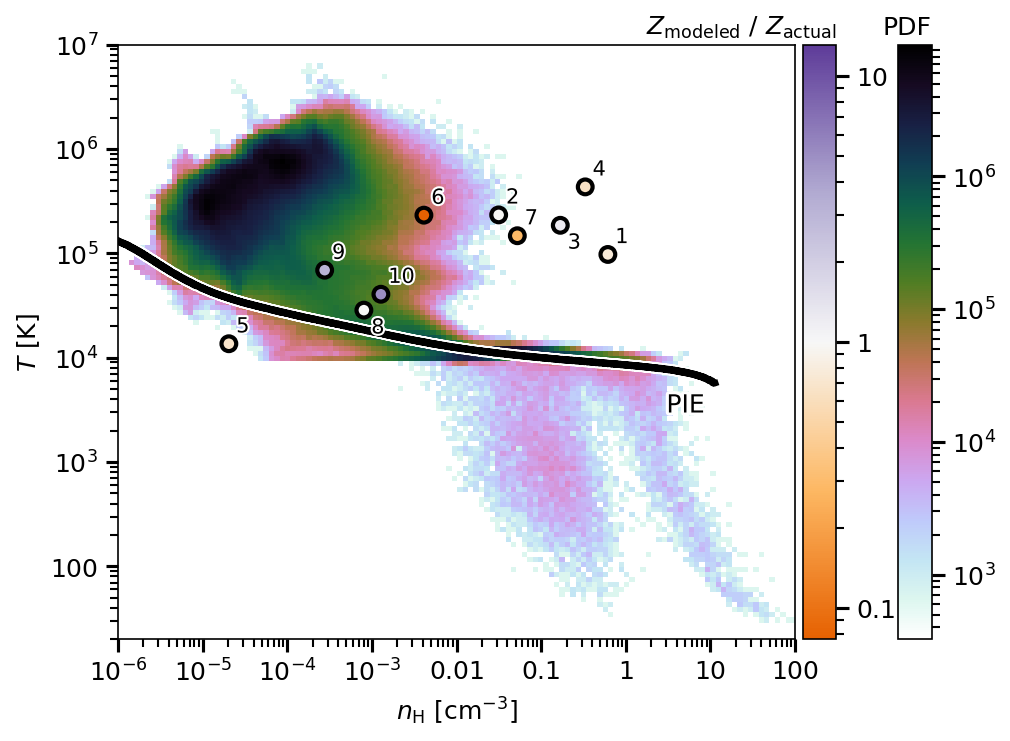

In [47]:
matplotlib.style.use( '/Users/zhafen/repos/clean-bold/clean-bold.mplstyle' )

fig = plt.figure( facecolor='w' )
ax = plt.gca()

ax.set_xscale( 'log' )
ax.set_yscale( 'log' )

img = ax.pcolormesh(
    10.**phase_diagram['logH_density_edges'],
    10.**phase_diagram['logT_edges'],
    pdf.transpose(),
#     extent = [ logHDen_centers[0], logHDen_centers[-1], logT_centers[0], logT_centers[-1] ],
    cmap = palettable.cubehelix.classic_16_r.mpl_colormap,
    norm = matplotlib.colors.LogNorm(),
)

logc = found['Z'] - actual['Z']
c = 10.**logc
logvlim = np.nanmax( np.abs( logc ) )
vmin = 10.**-logvlim
vmax = 10.**logvlim
scatter = ax.scatter(
    actual['H_density'],
    actual['temperature'],
    edgecolor = 'k',
    s = 50,
#     c = pdf_values,
    c = c,
    cmap = agreement_cmap,
    norm = matplotlib.colors.LogNorm( vmin, vmax ),
    linewidth = 2,
)

# Labels
voronoi_scatter.scatter(
    actual['H_density'],
    actual['temperature'],
    labels = np.arange( actual['H_density'].size ) + 1,
    ax = ax,
    plot_scatter = False,
    xlim = [ 1e-6, 100 ],
    ylim = [ 20, 1e7 ],
)
    
# Add line for PIE
pie_line = ax.plot(
    10.**lognH_pie,
    10.**logT_pie,
    color = 'k',
    linewidth = 3,
)
pie_line[0].set_path_effects([
    path_effects.Stroke(linewidth=5, foreground='w'),
    path_effects.Normal()
])
text = ax.annotate(
    'PIE',
    10.**np.array([ lognH_pie[-1], logT_pie[-1] ]),
    xycoords = 'data',
    xytext = ( -5, -5 ),
    textcoords = 'offset points',
    color = 'k',
    ha = 'right',
    va = 'top',
)
text.set_path_effects([
    path_effects.Stroke(linewidth=3, foreground='w'),
    path_effects.Normal()
])

# Colorbars
# Create divider for existing axes instance
divider = make_axes_locatable(ax)
# Append axes to the right of ax, with 5% width of ax
cax = divider.append_axes("right", pad=0.05, size='5%')
cb = plt.colorbar( scatter, cax=cax )
cax.annotate(
    text = r'$Z_{\rm modeled}$ / $Z_{\rm actual}$',
    xy = ( 1, 1 ),
    xytext = ( 0, 5 ),
    xycoords = 'axes fraction',
    textcoords = 'offset points',
    ha = 'right',        
)
cax = divider.append_axes("right", pad=0.41, size='5%')
cb = plt.colorbar( img, cax=cax )
cax.annotate(
    text = 'PDF',
    xy = ( 1, 1 ),
    xytext = ( 0, 5 ),
    xycoords = 'axes fraction',
    textcoords = 'offset points',
    ha = 'right',        
)


# ax.tick_params( length=15, width=3, labelsize=24 )
# ax.tick_params( which='minor', length=15 / 2, width=3./2, labelsize=24 )

ax.set_xlabel( r'$n_{\rm H}$ [cm$^{-3}$]' )
ax.set_ylabel( r'$T$ [K]', )

# ax.set_ylim( logT_centers[0], 7 )
# ax.set_xlim( -6, 2 )

# ax.set_aspect( 'equal' )

savefile = os.path.join( figure_dir, 'phase_space.png' )
print( 'Saving at {}'.format( savefile ) )
plt.savefig( savefile, bbox_inches='tight' )

## Comparison Including Expected Frequency

In [48]:
y_labels = {
    'metallicity': r'$\log_{10} ( Z_{\rm modeled}/Z_{\rm actual} )$',
    'H_density': r'$\log_{10} ( n_{\rm H, modeled}/n_{\rm H, actual} )$',
    'temperature': r'$\log_{10} ( T_{\rm modeled}/T_{\rm actual} )$',
    'length': r'$\log_{10} (\ell_{\rm modeled} / \ell_{\rm actual} )$',
}

### Ratios on Y-Axis

In [49]:
vmin = np.nanmin( pdf[np.nonzero(pdf)] )
vmax = np.nanmax( pdf[np.nonzero(pdf)] )

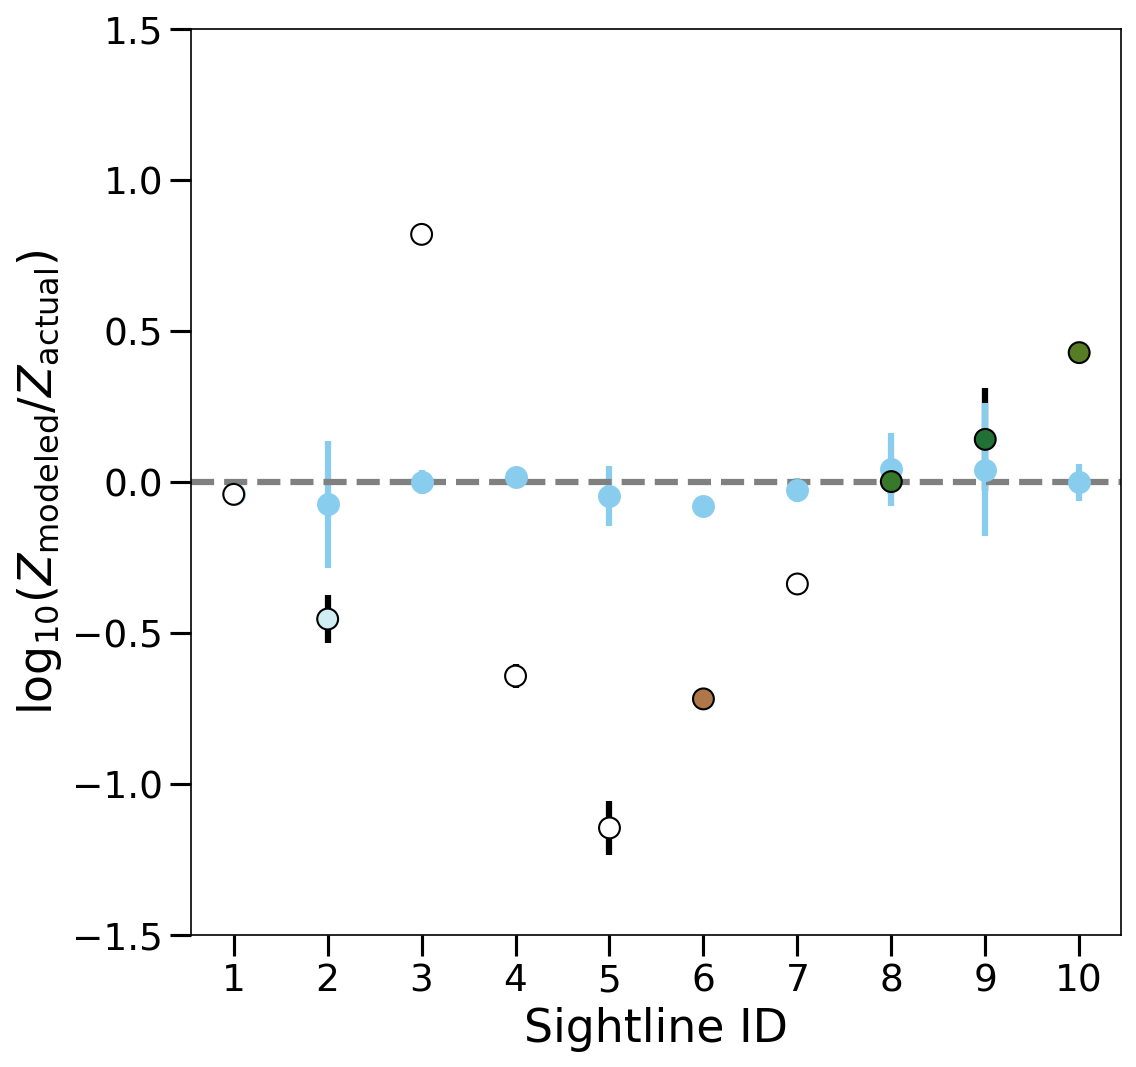

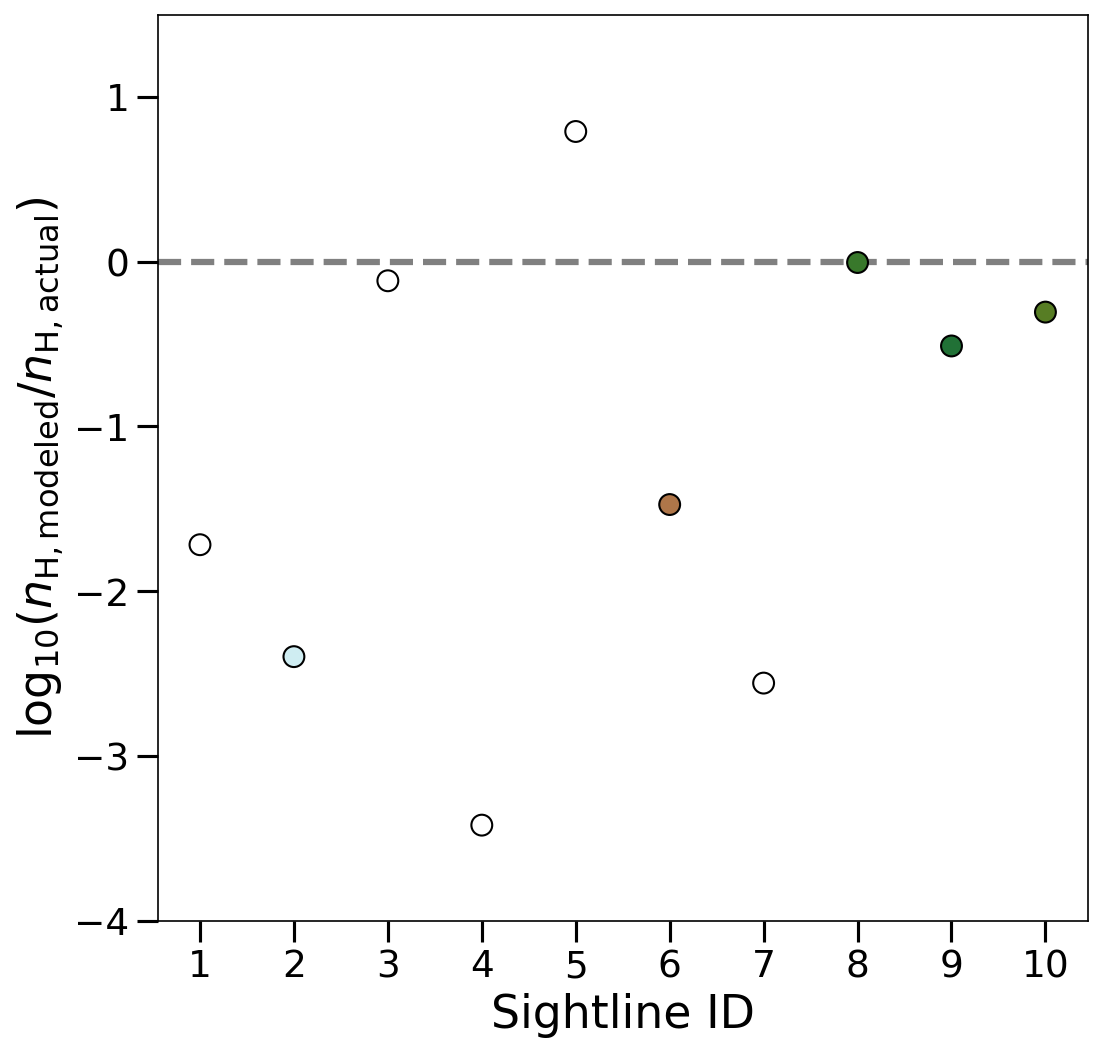

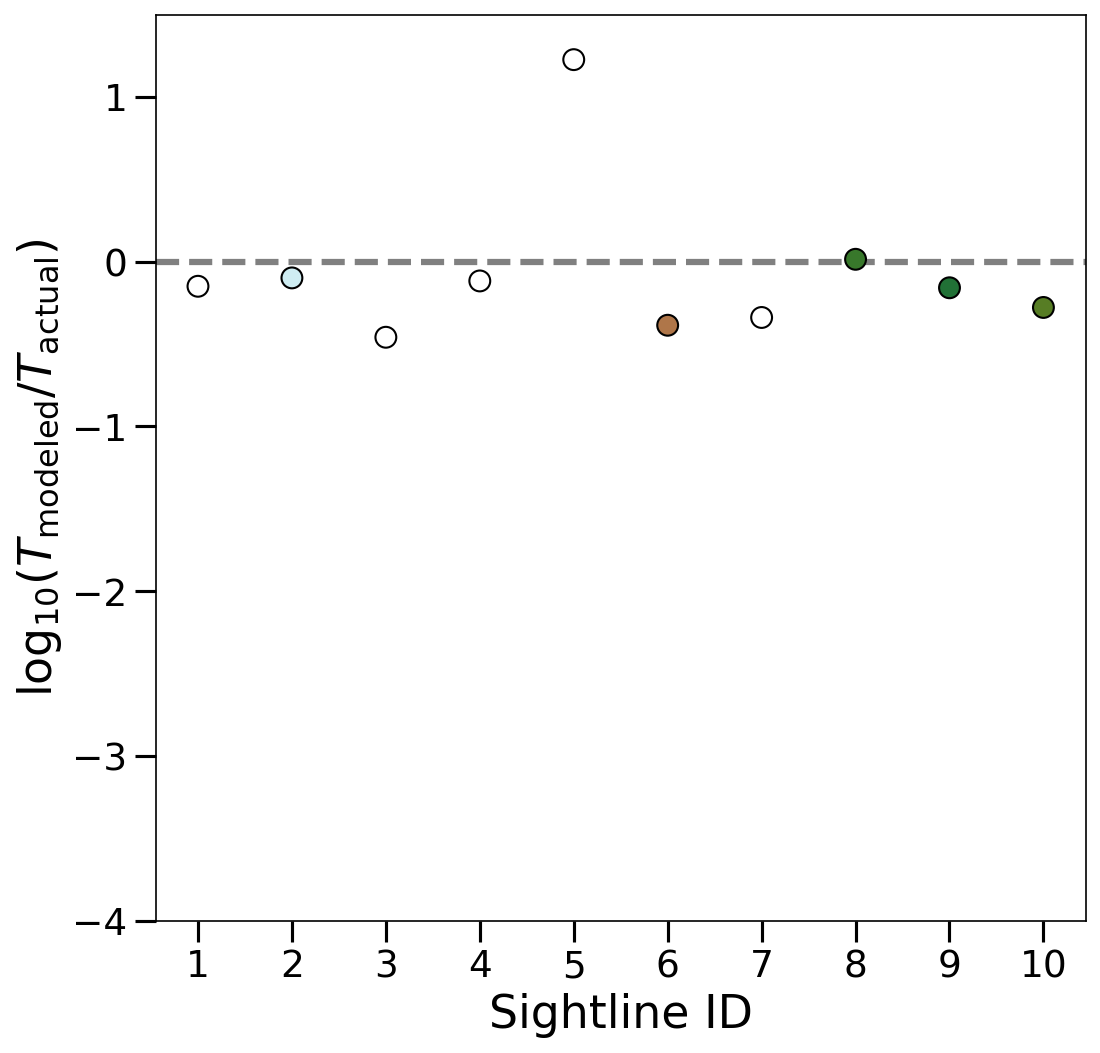

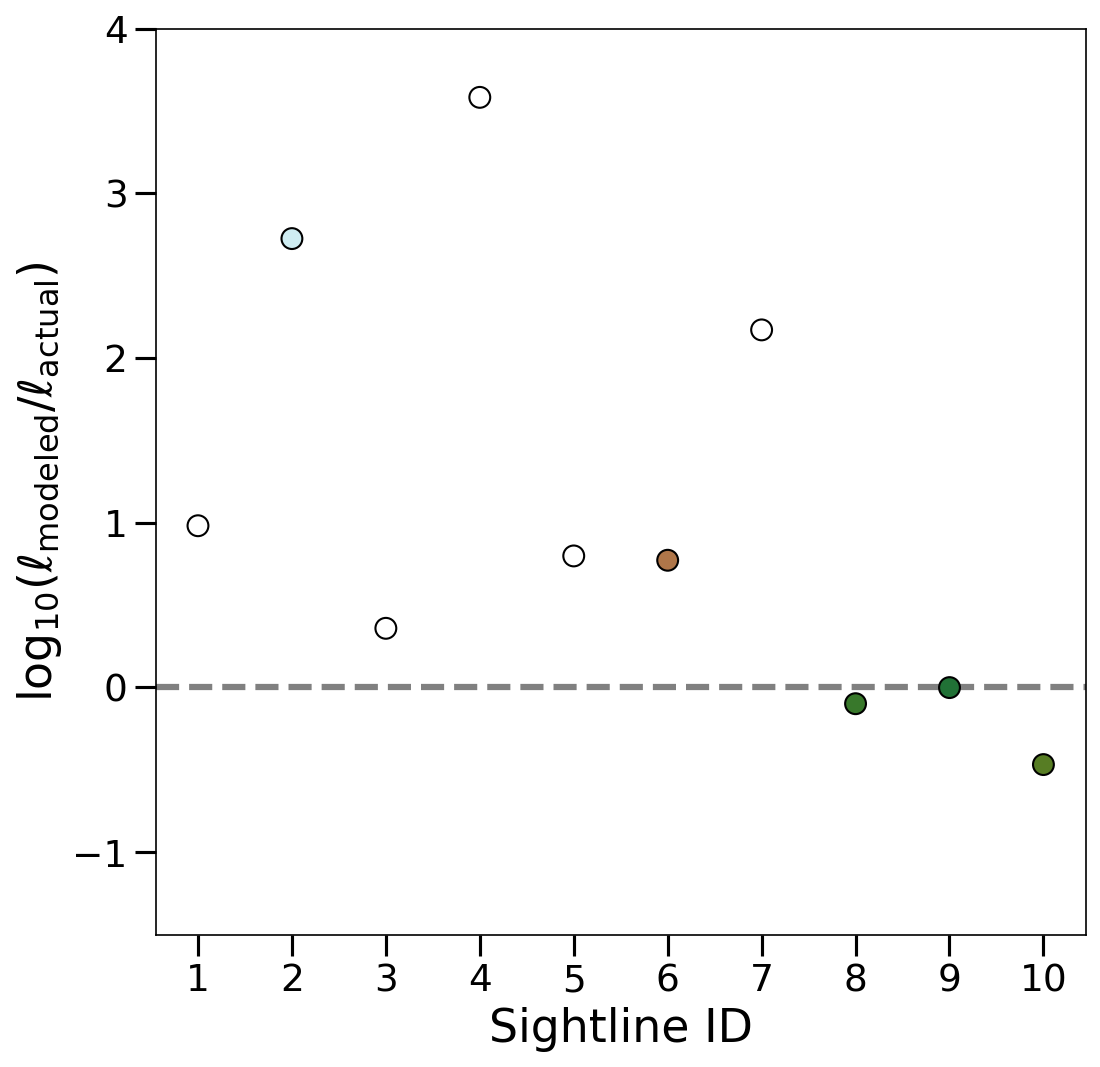

In [50]:
for key in [ 'metallicity', 'H_density', 'temperature', 'length' ]:

    fig = plt.figure( figsize=(8,8), facecolor='w' )
    ax = plt.gca()

    if key != 'length':
        ys = modeled[key] - np.log10( actual[key] )
    else:
        ys = np.log10( modeled[key] / actual[key] )
        
    ax.scatter(
        np.arange( actual[key].size ) + 1,
        ys,
        edgecolor = 'k',
        s = 100,
        c = pdf_values,
        cmap = palettable.cubehelix.classic_16_r.mpl_colormap,
        norm = matplotlib.colors.LogNorm( vmin, vmax ),
    )

    if key == 'metallicity':
        
        ax.errorbar(
            np.arange( actual[key].size ) + 1,
            modeled[key] - np.log10( actual[key] ),
            yerr = modeled['emetallicity'],
            linestyle = 'none',
            color = 'k',
            zorder = -10,
        )
        
        ax.scatter(
            np.arange( actual[key].size ) + 1,
            revised['Z'] - np.log10( actual[key] ),
            s = 100,
            color = revised_color,
            zorder = -9,
        )
        ax.errorbar(
            np.arange( actual[key].size ) + 1,
            revised['Z'] - np.log10( actual[key] ),
            yerr = revised['errZ'],
            linestyle = 'none',
            color = revised_color,
            zorder = -10,
        )
        
#         # Mohapatra results
#         ax.errorbar(
#             np.arange( actual[key].size ) + 1,
#             met_mohapatra,
#             yerr = emet_mohapatra,
#             marker = 's',
#             markersize = 10,
#             color = colormap[1],
#             linestyle = 'none',
#             label = 'Mohapatra',
#             zorder = -10
#         )
#         ax.plot(
#             [ 9, ]*2,
#             [ 0.54, 1000 ],
#             color = colormap[1],
#         )

    ax.axhline(
        0,
        color = '0.5',
        linestyle = '--',
        linewidth = 3,
        zorder = -10,
    )

    plt.xticks( np.arange( actual['metallicity'].size ) + 1, )
    ax.tick_params( length=10, width=1.5, labelsize=18 )

    ax.set_xlabel( r'Sightline ID', fontsize=22 )
    ax.set_ylabel( y_labels[key], fontsize=22 )
    
    if key == 'length':
        ax.set_ylim( -1.5, 4 )
    elif key == 'metallicity':
        ax.set_ylim( -1.5, 1.5 )
    else:
        ax.set_ylim( -4, 1.5 )
        
#     plt.savefig( './figures/sample0/comparison_{}_inc_freq.pdf'.format( key ), bbox_inches='tight' )

### Properties on Y-axis

In [51]:
clean_mosaic = [
    [ 'Z', 'T', ],
    [ 'nH', 'l' ],
]

In [52]:
y_labels = {
    'Z': r'$Z_{\rm modeled}$ / $Z_{\rm actual}$',
    'nH': r'$n_{\rm H, modeled}$ / $n_{\rm H, actual}$',
    'T': r'$T_{\rm modeled}$ / $T_{\rm actual}$',
    'l': r'$\ell_{\rm modeled}$  / $\ell_{\rm actual}$',
}

Saving at /Users/zhafen/paper_repos/cgm_modeling_challenge_paper/figures/sample0/comparison.pdf


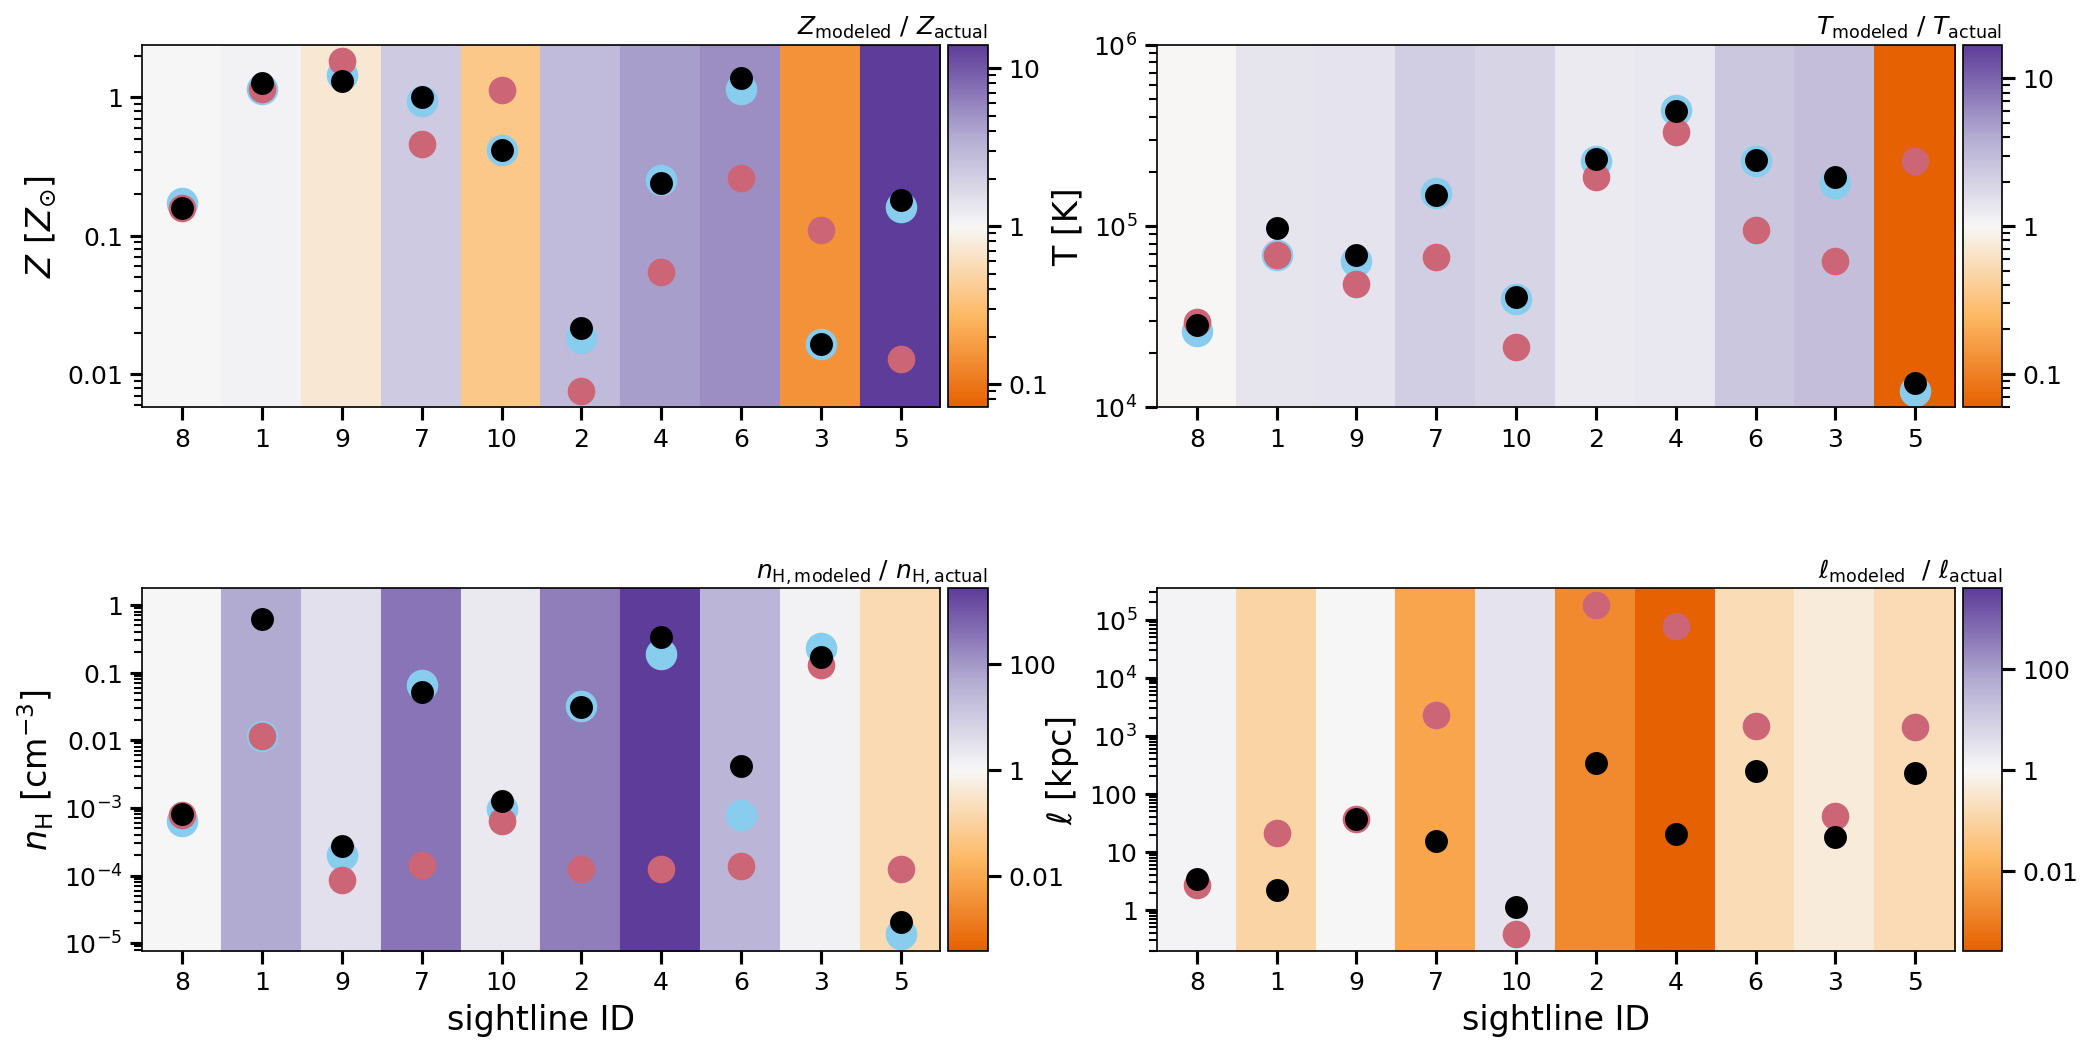

In [53]:
# Setup Figure
n_rows_clean = 2
n_cols_clean = 2
aspect_ratio = 2
fig = plt.figure( figsize=(n_cols_clean*panel_length*aspect_ratio, n_rows_clean*panel_length), facecolor='w' )
ax_dict = fig.subplot_mosaic(
    clean_mosaic,
    gridspec_kw = { 'hspace': 0.5 },
)

ratio = actual['Z'] / found['Z']
ordered_inds = np.argsort( np.abs( np.log10( ratio ) ) )

for key in prop_keys:
    
    ax = ax_dict[key]
    
    ratio = actual[key] / found[key]
    
    ratio_loglim = np.nanmax( np.abs( np.log10( actual[key] / found[key] ) ) )
    ratio_min = 10.**-ratio_loglim
    ratio_max = 10.**ratio_loglim
    
    # Shade regions
    norm = matplotlib.colors.LogNorm( vmin=ratio_min, vmax=ratio_max )
    for i, c_value in enumerate( ratio[ordered_inds] ):
        
        c = agreement_cmap( norm( c_value ) )
        
        ax.fill_between(
            [ xs[i] - 0.5, xs[i] + 0.5 ],
            [ 0, 0 ],
            [ 1, 1 ],
            transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
            color = c,
        )
    
    # Actual
    ax.scatter(
        xs,
        actual[key][ordered_inds],
        s = 100,
        color = 'k',
#         edgecolor = 'k',
#         c = pdf_values[ordered_inds],
#         cmap = palettable.cubehelix.classic_16_r.mpl_colormap,
#         norm = matplotlib.colors.LogNorm( vmin, vmax ),
        zorder = 100,
    )
    
    # Original
    ax.scatter(
        xs,
        found[key][ordered_inds],
        color = found_color,
        s = 150,
        zorder = 50,
    )
    
    # Revised
    try:
        ax.scatter(
            xs,
            found_revised[key][ordered_inds],
            color = revised_color,
            s = 200,
        )
    except KeyError:
        pass
    
    if logscale[key]:
        ax.set_yscale( 'log' )
        
    # X ticks
    ax.set_xticks( xs )
    ax.set_xticklabels( ordered_inds + 1 )
    
    ax.set_xlim( xs[0] - 0.5, xs[-1] + 0.5 )
    if key in lims:
        ax.set_ylim( lims[key] )
        
        
    # Colorbars
    # Create divider for existing axes instance
    divider = make_axes_locatable( ax )
    # Append axes to the right of ax, with 5% width of ax
    cax = divider.append_axes("right", pad=0.05, size='5%')
    cb = matplotlib.colorbar.ColorbarBase( cax, cmap=agreement_cmap, norm=norm )
    cax.annotate(
        text = y_labels[key],
        xy = ( 1, 1 ),
        xytext = ( 0, 5 ),
        xycoords = 'axes fraction',
        textcoords = 'offset points',
        ha = 'right',        
    )
    
# Cleanup
for x_key, ax in ax_dict.items():
    
    if x_key == 'legend':
        continue
    
    subplotspec = ax.get_subplotspec()
        
    ax.set_ylabel( labels[x_key], fontsize=16 )
    if subplotspec.is_last_row():
        ax.set_xlabel( 'sightline ID', fontsize=16 )
        
savefile = os.path.join( figure_dir, 'comparison.pdf' )
print( 'Saving at {}'.format( savefile ) )
plt.savefig( savefile, bbox_inches='tight' )

## Corner Plot Comparison

### Plot

In [54]:
mosaic = [
    [ 'l', 'legend', '.', '.' ],
    [ 'T_l', 'T', '.', '.' ],
    [ 'nH_l', 'nH_T', 'nH', '.' ],
    [ 'Z_l', 'Z_T', 'Z_nH', 'Z', ],
]

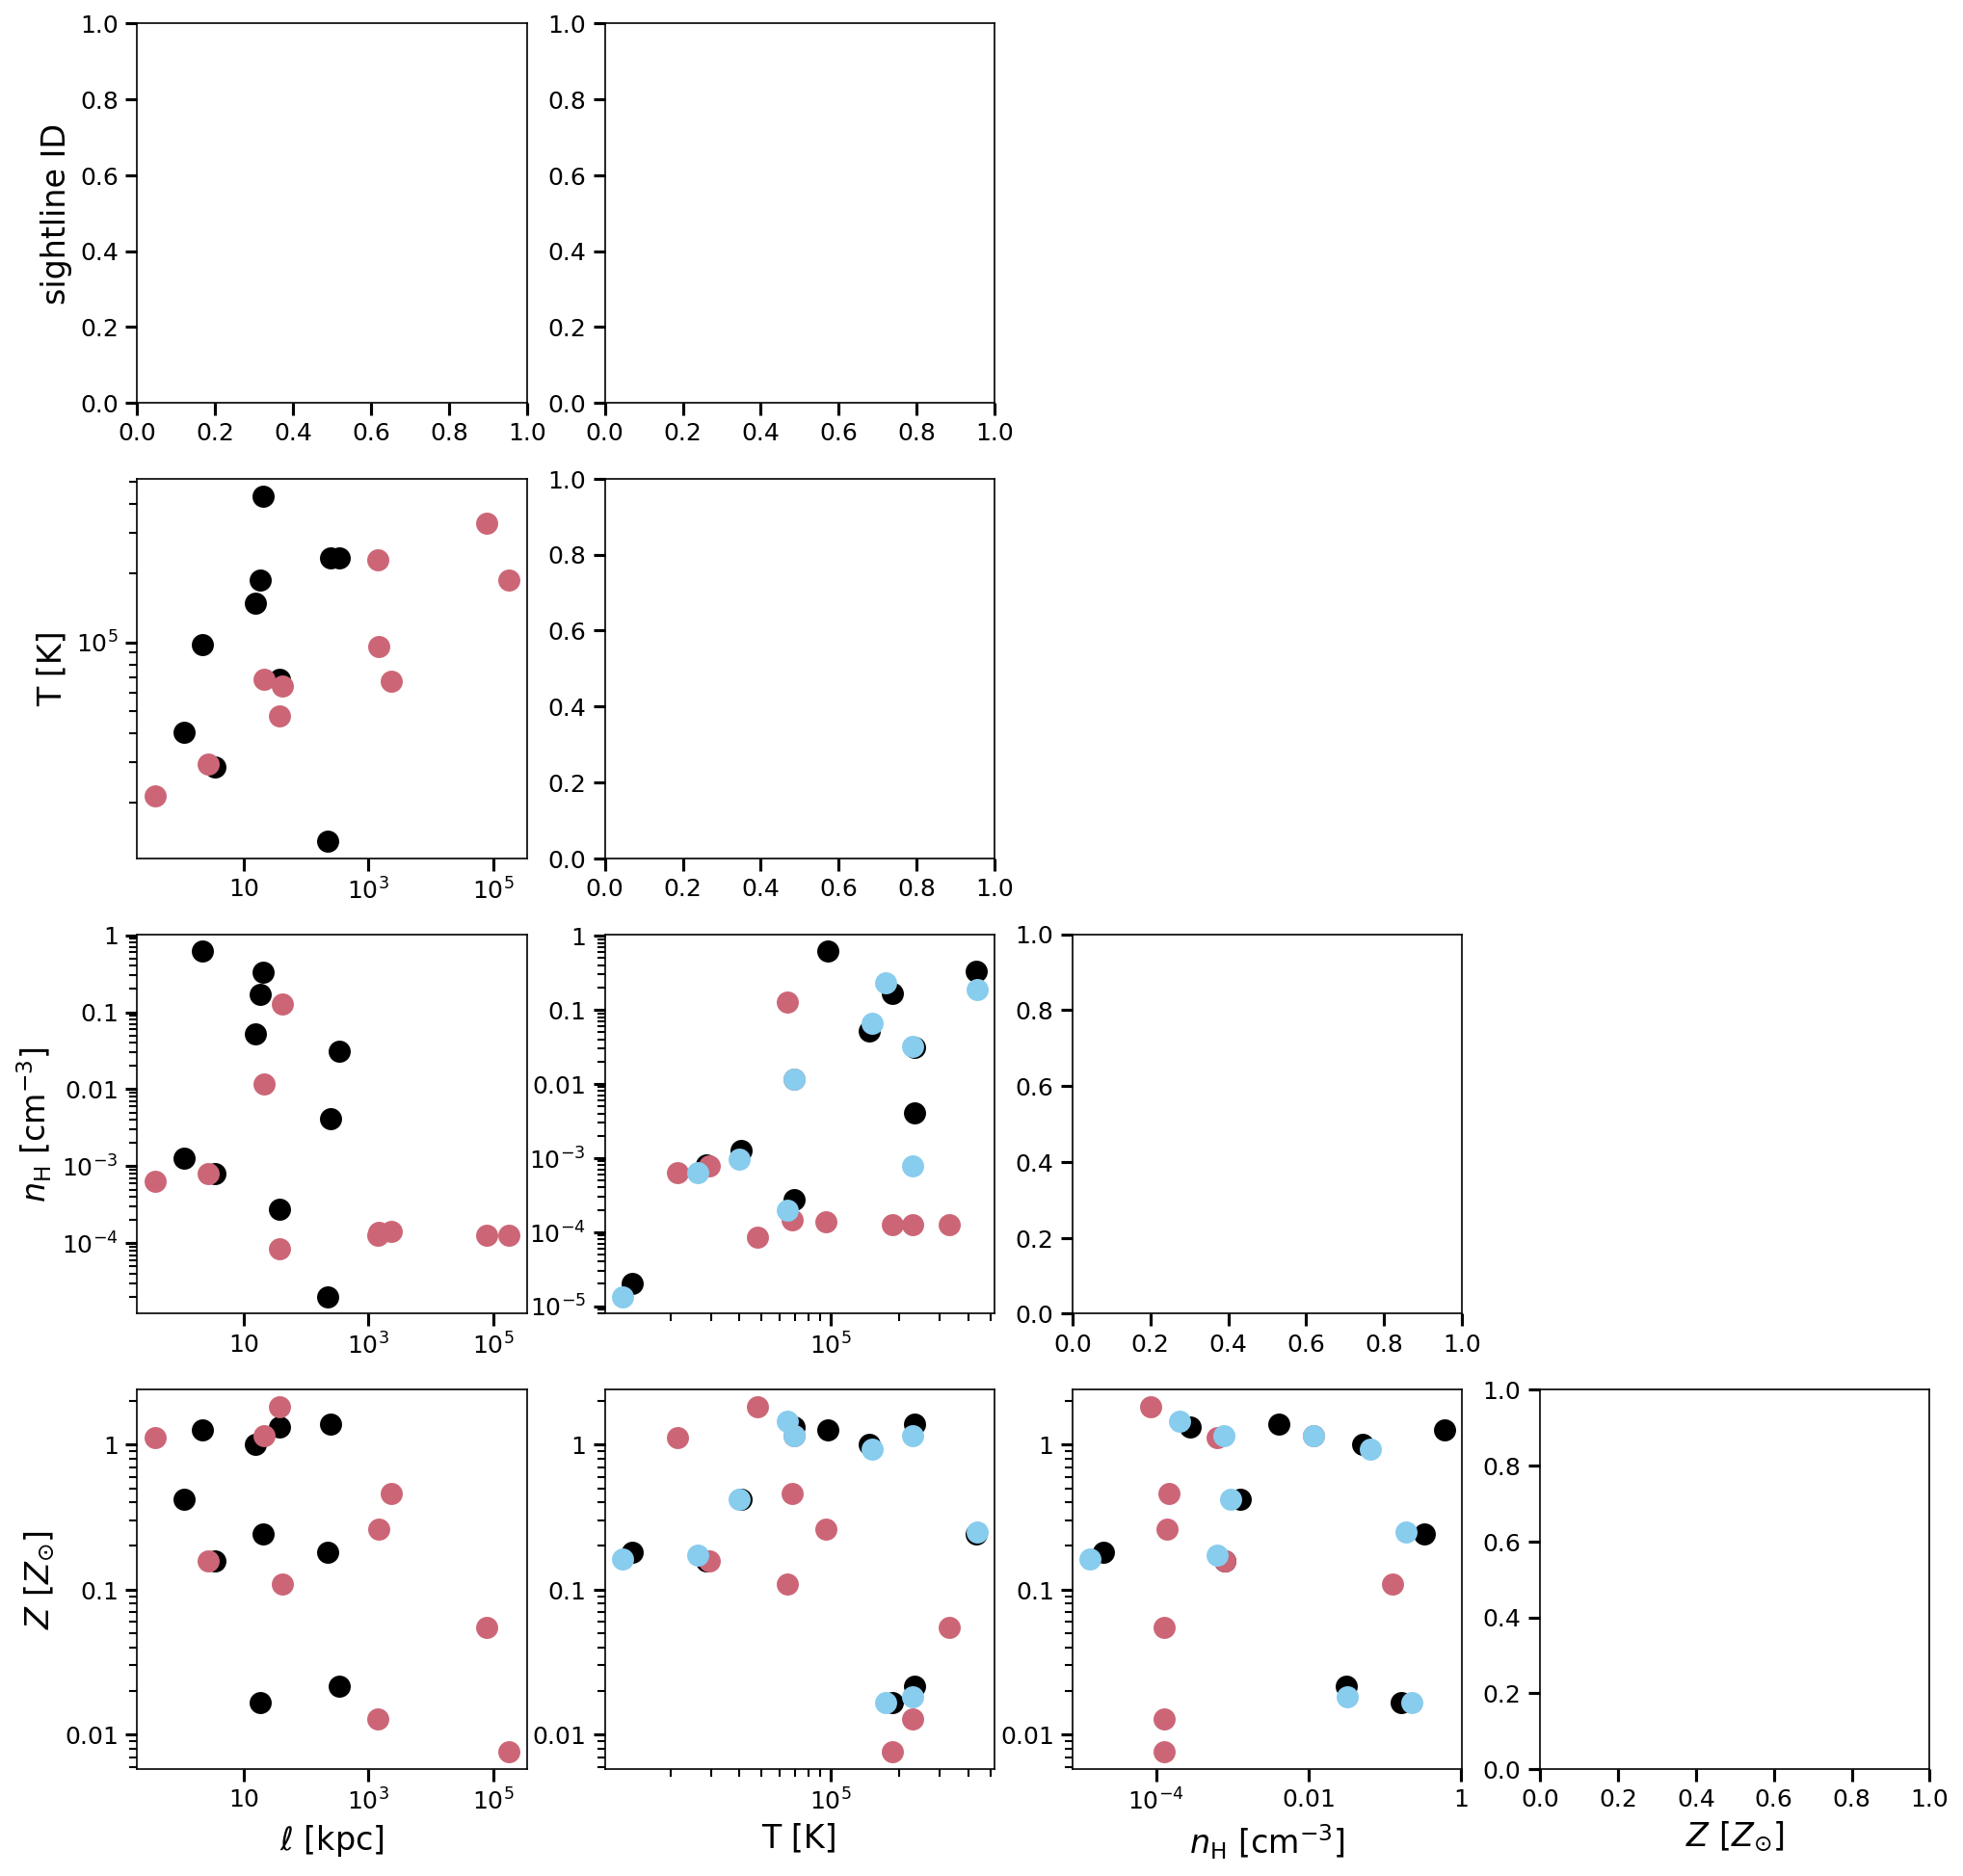

In [55]:
# Setup Figure
n_cols = len( prop_keys )
fig = plt.figure( figsize=( panel_length*n_cols, panel_length*n_cols ), facecolor='w' )
ax_dict = fig.subplot_mosaic(
    mosaic,
)

# Loop through all properties
for j, x_key in enumerate( prop_keys ):
    for k, y_key in enumerate( prop_keys ):

        # Avoid duplicates
        if k < j:
            continue 
            
        # Single property comparison
        if j == k:
            ax = ax_dict[x_key]
            subplotspec = ax.get_subplotspec()
            
            x_label = labels[x_key]
            y_label = 'sightline ID'
                        
        # 2D comparisons
        else:
            try:
                ax = ax_dict['{}_{}'.format( x_key, y_key )]
            except KeyError:
                ax = ax_dict['{}_{}'.format( y_key, x_key )]
            subplotspec = ax.get_subplotspec()
            
            # Actual values
            ax.scatter(
                actual[x_key],
                actual[y_key],
                color = 'k',
            )
            
            # Modeled values
            ax.scatter(
                found[x_key],
                found[y_key],
                color = found_color,
            )
            
            # Revised modeled values
            try:
                ax.scatter(
                    found_revised[x_key],
                    found_revised[y_key],
                    color = revised_color,
                )
            except KeyError:
                pass
            
            if logscale[x_key]:
                ax.set_xscale( 'log' )
            if logscale[y_key]:
                ax.set_yscale( 'log' )
                
            x_label = labels[x_key]
            y_label = labels[y_key]

        if subplotspec.is_last_row():
            ax.set_xlabel( x_label, fontsize=16 )
        if subplotspec.is_first_col():
            ax.set_ylabel( y_label, fontsize=16 )

## How Much Column Density Agreement is Enough?

### Overview

In [56]:
inds = np.arange( ordered_inds.size )

In [57]:
ions = [ 'H I', 'Si II', 'Si III', 'Si IV', 'N II', 'N III', 'N V', 'C II', 'C III', 'O I', 'O VI', ]

Saving at /Users/zhafen/paper_repos/cgm_modeling_challenge_paper/figures/sample0/column_den_all.pdf


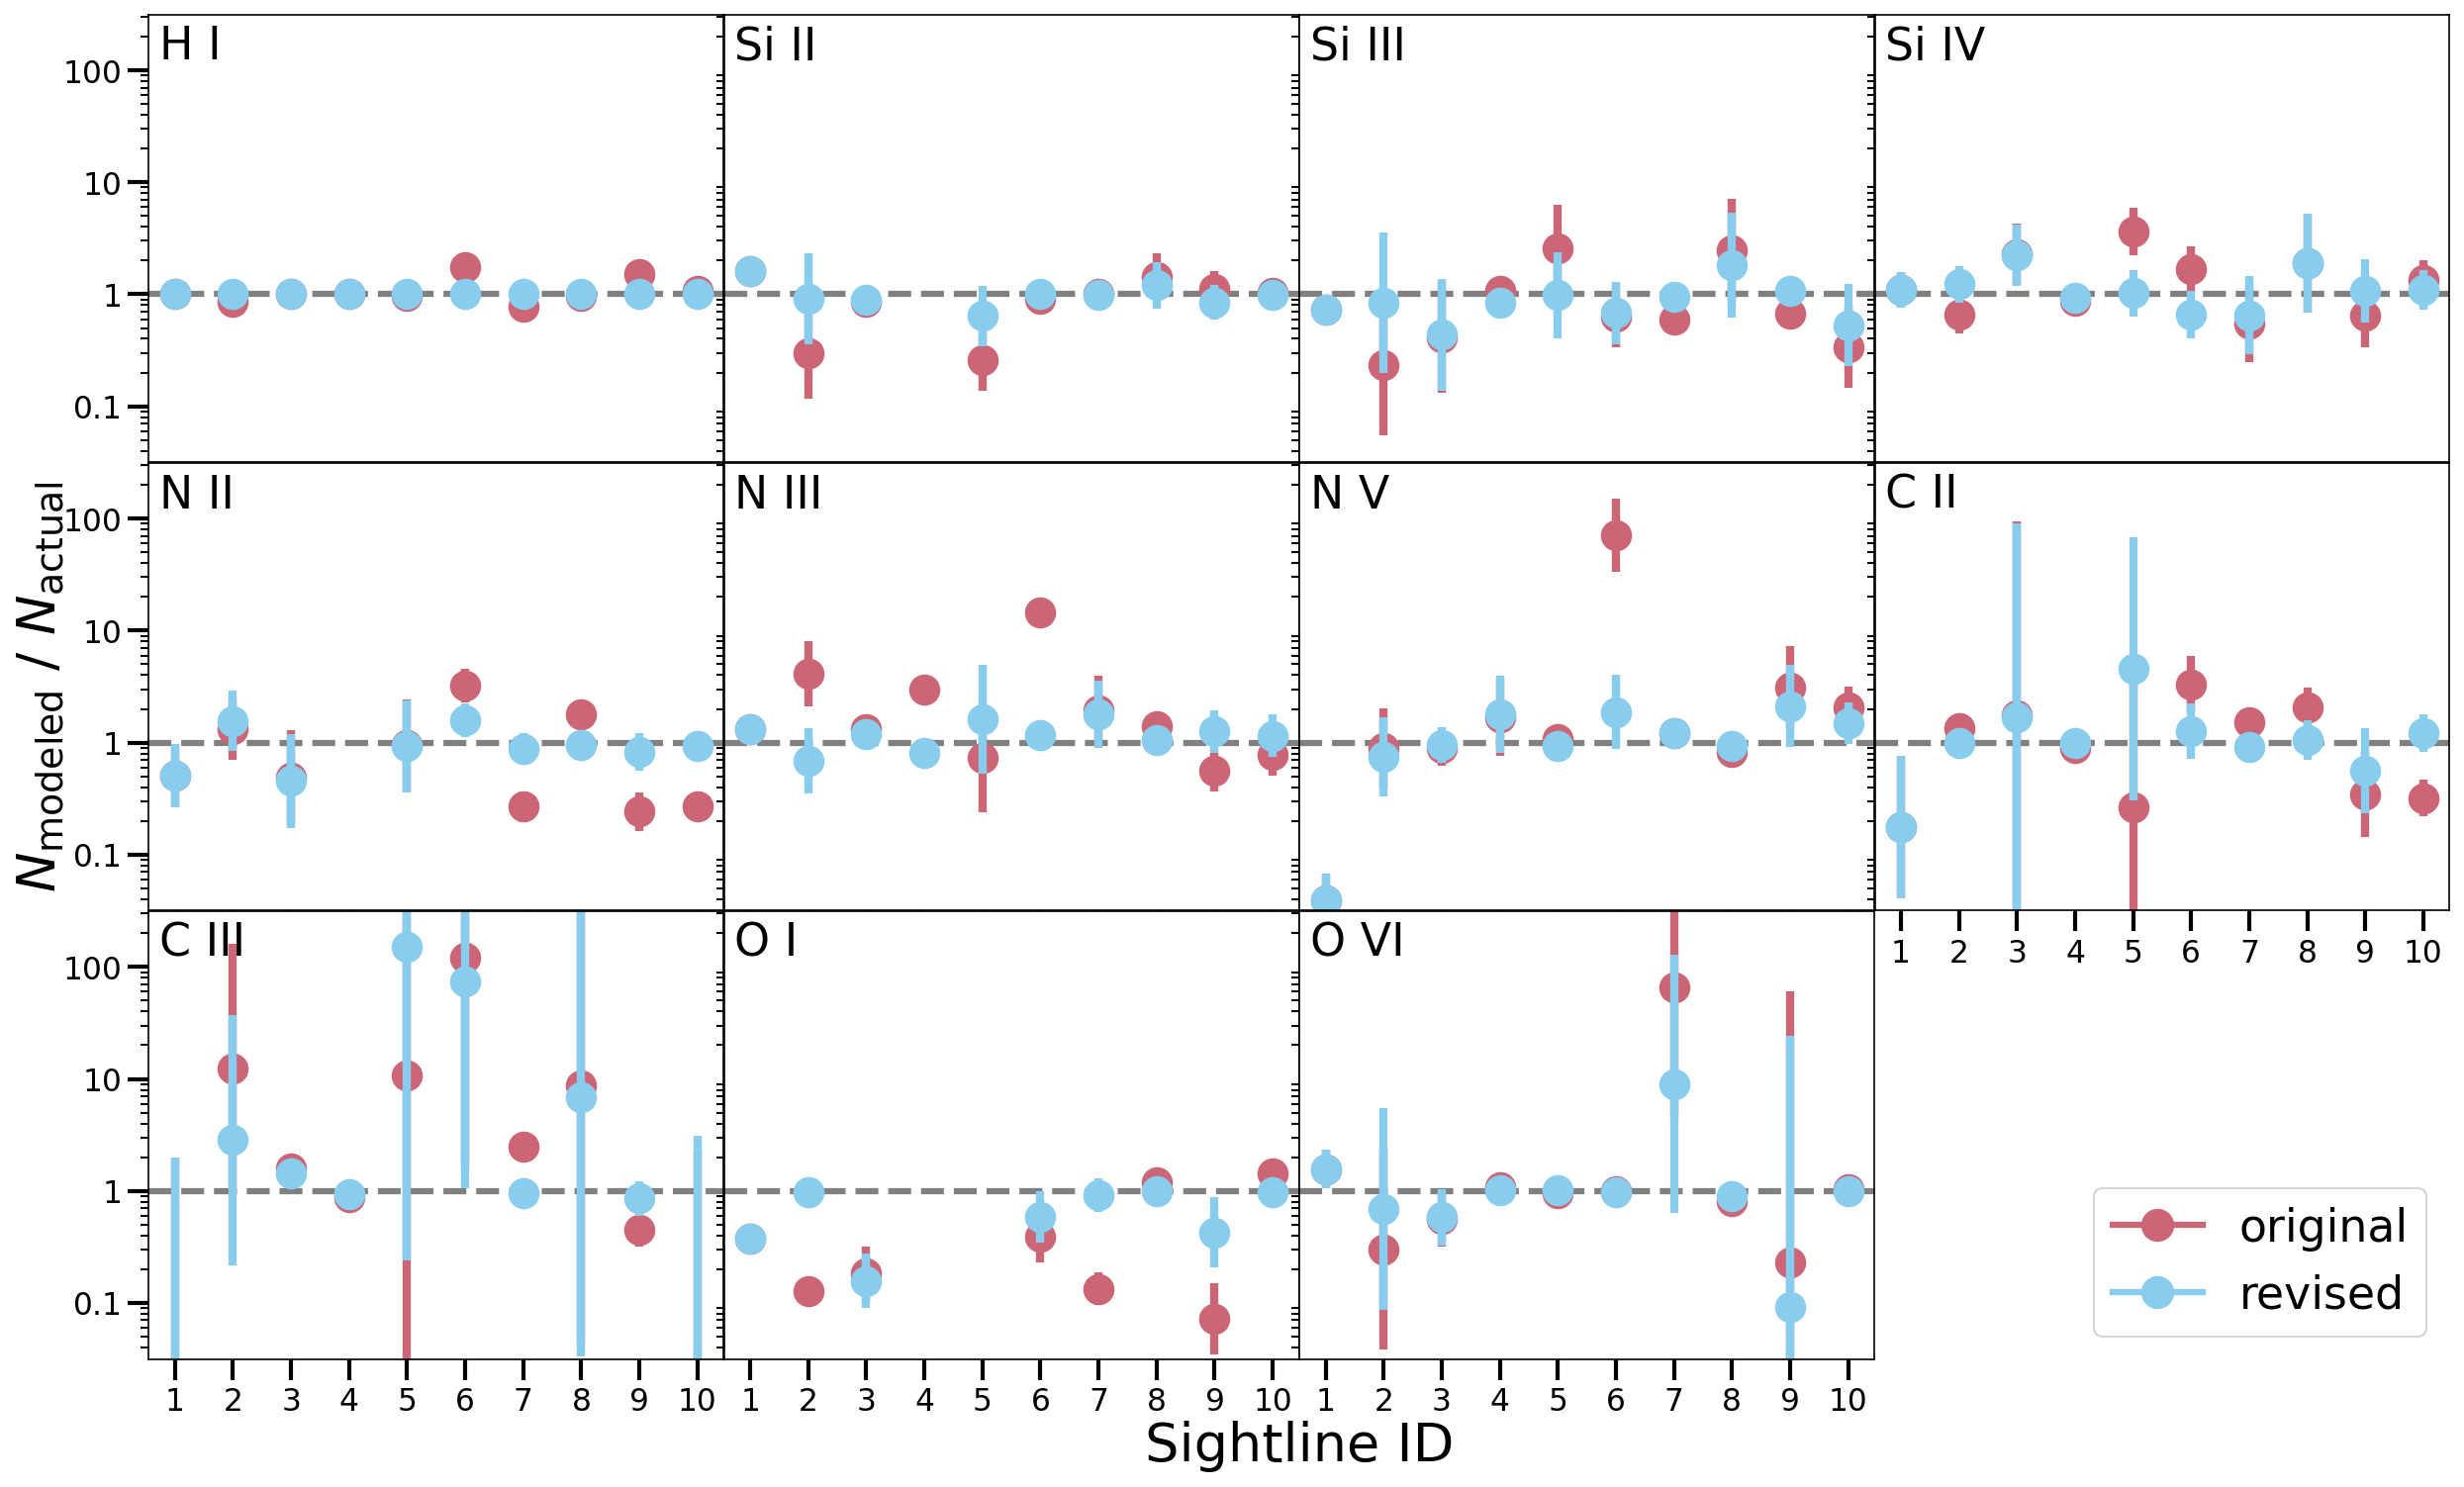

In [58]:
n_rows = 3
n_cols = 4
fig = plt.figure( figsize=(n_cols*5,n_rows*4), facecolor = 'w' )
ax = plt.gca()

gs = matplotlib.gridspec.GridSpec( n_rows, n_cols )

gs.update( hspace=0.001, wspace=0.001 )

i = 0
j = 0
for k, ion in enumerate( ions ):
    
    ax_ij = fig.add_subplot( gs[j,i] )
    
    def convert_to_linear( ylog_, yerr_log_ ):
        y_ = 10.**ylog_
        yerr_ = 10.**np.array([ ylog_ - yerr_log_, ylog_ + yerr_log_ ])
        yerr_[0] = y_ - yerr_[0]
        yerr_[1] = yerr_[1] - y_
        return y_, yerr_
    
    ylog = modeled[ion.replace( ' ', '' )][inds+1] - provided[ion]['logN'][inds]
    yerr_log = provided[ion]['elogN'][inds]
    y, yerr = convert_to_linear( ylog, yerr_log )
    ax_ij.scatter(
        np.arange( inds.size ),
        y,
        color = found_color,
        s = 200,
        label = 'original',
        zorder = -1,
    )
    
    ax_ij.errorbar(
        np.arange( inds.size ),
        y,
        yerr = yerr,
        linestyle = 'none',
        color = found_color,
        zorder = -5,
        linewidth = 4,
    )
    
    ylog = revised[ion.replace( ' ', '' )][inds+1] - provided[ion]['logN'][inds]
    yerr_log = provided[ion]['elogN'][inds]
    y, yerr = convert_to_linear( ylog, yerr_log )
    ax_ij.scatter(
        np.arange( inds.size ),
        y,
        s = 200,
        color = revised_color,
        zorder = 2,
        label = 'revised',
    )
    ax_ij.errorbar(
        np.arange( inds.size ),
        y,
        yerr = yerr,
        linestyle = 'none',
        color = revised_color,
        zorder = 1,
        linewidth = 4,
    )
    
#     ax_ij.scatter(
#         inds + 1,
#         np.log10( actual[ion][inds] ),
#         color = 'k',
#     )

    ax_ij.axhline(
        1,
        color = '0.5',
        linestyle = '--',
        linewidth = 3,
        zorder = -10,
    )
    
    ax_ij.annotate(
        text = ion,
        xy = (0, 1),
        xycoords = 'axes fraction',
        xytext = ( 5, -5 ),
        textcoords = 'offset points',
        va = 'top',
        ha = 'left',
        fontsize = 22,
    )
    
    ax_ij.set_yscale( 'log' )
    ax_ij.set_ylim( 10.**np.array([-1.5, 2.5]) )
    
    # Adjust ticks
    plt.xticks( np.arange( inds.size ), inds + 1 )
    ax_ij.tick_params( which='major', labelsize=15, size=10, width=2 )
    if i != 0:
        ax_ij.tick_params( left=False, labelleft=False )
    
    # Move to next axis in line
    if i > n_rows - 1:
        j += 1
        i = 0
    else:
        i += 1
        
        
handles = [
    matplotlib.lines.Line2D([0], [0], marker='o', color=found_color, label='original', markersize=15),
    matplotlib.lines.Line2D([0], [0], marker='o', color=revised_color, label='revised', markersize=15),
]

ax.legend(
    handles = handles,
    loc = 'lower right',
    prop = { 'size': 22 },
)

# Removing spines and tick marks
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params( bottom=False, left=False, labelleft=False, labelbottom=False )

ax.set_xlabel( 'Sightline ID', fontsize=26, labelpad=30 )
ax.set_ylabel( r'$N_{\rm modeled}$ / $N_{\rm actual}$', fontsize=26, labelpad=40 )

savefile = os.path.join( figure_dir, 'column_den.pdf' )
print( 'Saving at {}'.format( savefile ) )
plt.savefig( savefile, bbox_inches='tight' )

### Vs Average Agreement

In [76]:
# Calculate weighted error
avg_errors = []
avg_actual_errors = []
for obs_data in [ modeled, revised ]:
    sum_error = np.zeros( obs_data.shape[0] )
    sum_actual_error = np.zeros( obs_data.shape[0] )
    sum_weights = np.zeros( obs_data.shape[0] )
    for ion in provided.keys():
        modeled_values = obs_data[ion.replace( ' ', '' )].values
        error = provided[ion]['logN'] - modeled_values
        actual_error = np.log10( actual[ion] ) - modeled_values
        weight = 1. / provided[ion]['elogN']

        # Deal with infinite values
        invalid = np.invert(np.isfinite( provided[ion]['logN'] ) )
        error[invalid] = 0.
        actual_error[invalid] = 0.
        weight[invalid] = 0.

        sum_error += np.abs( error ) * weight 
        sum_actual_error += np.abs( actual_error ) * weight
        sum_weights += weight
        
    avg_errors.append( sum_error / sum_weights )
    avg_actual_errors.append( sum_actual_error / sum_weights )
avg_error_modeled, avg_error_revised = avg_errors
avg_actual_error_modeled, avg_actual_error_revised = avg_actual_errors

/var/folders/8x/jtlm_9mn1gd4ptwqw1yvxfrm0000gn/T/ipykernel_19064/3957233029.py:11: RuntimeWarning: divide by zero encountered in log10
  actual_error = np.log10( actual[ion] ) - modeled_values


Saving at /Users/zhafen/paper_repos/cgm_modeling_challenge_paper/figures/sample0/error_vs_error.pdf


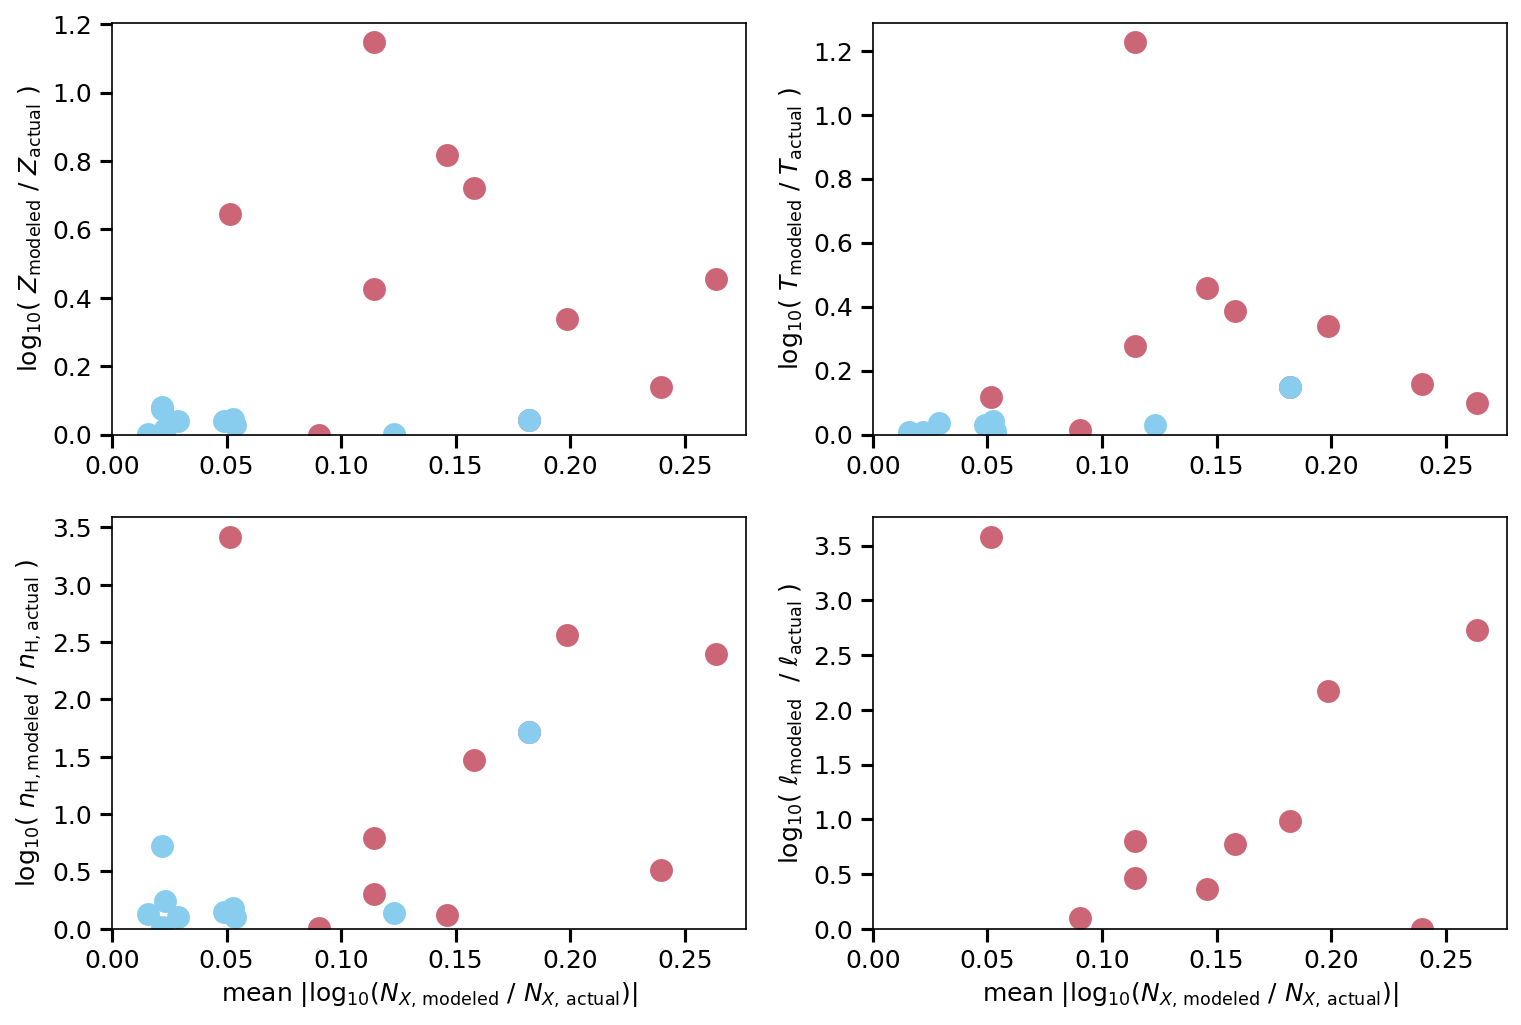

In [105]:
# Setup Figure
n_rows_clean = 2
n_cols_clean = 2
aspect_ratio = 1.5
fig = plt.figure( figsize=(n_cols_clean*panel_length*aspect_ratio, n_rows_clean*panel_length), facecolor='w' )
ax_dict = fig.subplot_mosaic(
    clean_mosaic,
#     gridspec_kw = { 'hspace': 0.5 },
)

for key in prop_keys:
        
    ax = ax_dict[key]
    
    ratio = np.abs( np.log10( found[key] / actual[key] ) )
    ax.scatter(
        avg_actual_error_modeled,
        ratio,
        color = found_color,
    )
    
    if key in found_revised:
        ratio_revised = np.abs( np.log10( found_revised[key] / actual[key] ) )
        ax.scatter(
            avg_actual_error_revised,
            ratio_revised,
            color = revised_color,
        )
        
    ax.set_xlim( 0, avg_actual_error_modeled.max() * 1.05 )
    ax.set_ylim( 0, ratio.max() * 1.05 )
    
    if ax.get_subplotspec().is_last_row():
        ax.set_xlabel( r'mean $\vert \log_{10} ( N_{X,\,{\rm modeled}}$ / $N_{X,\,{\rm actual}} ) \vert$' )
    ax.set_ylabel( r'$\log_{10}($ ' + y_labels[key] + r' $)$' )
    
#     ax.set_yscale( 'log' )

savefile = os.path.join( figure_dir, 'error_vs_error.pdf' )
print( 'Saving at {}'.format( savefile ) )
plt.savefig( savefile, bbox_inches='tight' )

## Noising of Data

In [ ]:
ions = list( provided.keys() )

In [ ]:

for ion in ions:
    fig = plt.figure( figsize=(8,8), facecolor='w' )
    ax = plt.gca()

    xs = np.log10( actual[ion] )
    ys = provided[ion]['logN']
    eys = provided[ion]['elogN']

    ax.errorbar(
        xs,
        ys,
        yerr = eys,
        marker = 'o',
        markersize = 10,
        color = 'k',
        linestyle = 'none',
    )

    bounds = [
        min( np.nanmin( xs[np.isfinite(xs)] ), np.nanmin( ys[np.isfinite(ys)] ) ) - 0.5,
        max( np.nanmax( xs[np.isfinite(xs)] ), np.nanmax( ys[np.isfinite(ys)] ) ) + 0.5,
    ]
    ax.plot(
        bounds,
        bounds,
        color = '0.5',
        linestyle = '--',
        linewidth = 3,
        zorder = -10,
    )
    
    ax.annotate(
        text = ion,
        xy = ( 0, 1 ),
        xycoords = 'axes fraction',
        xytext = ( 5, -5 ),
        textcoords = 'offset points',
        fontsize = 22,
        ha = 'left',
        va = 'top',
    )
    
    ax.tick_params( length=10, width=1.5, labelsize=18 )

    ax.set_xlabel( r'$\log_{10}( N_{\rm ion,\,actual} )$', fontsize=22, )
    ax.set_ylabel( r'$\log_{10}( N_{\rm ion,\,provided} )$', fontsize=22, )

    ax.set_xlim( bounds )
    ax.set_ylim( bounds )

    ax.set_aspect( 'equal' )